# Customer Lifetime Value Prediction by Using BG-NBD & Gamma-Gamma Models

dataset : https://archive.ics.uci.edu/dataset/352/online+retail

## Loading the Dataset & Checking Variables

In [1]:
#Loading the required libraries
import datetime as dt
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import \
    calibration_and_holdout_data, \
    summary_data_from_transaction_data, \
    calculate_alive_path
from lifetimes.plotting import \
    plot_frequency_recency_matrix, \
    plot_probability_alive_matrix, \
    plot_period_transactions, \
    plot_history_alive, \
    plot_cumulative_transactions, \
    plot_calibration_purchases_vs_holdout_purchases


import warnings
warnings.filterwarnings("ignore")


pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.0f}'.format

In [2]:
#Reading the online retail dataset
df = pd.read_csv("data.csv", encoding='unicode_escape')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,3,"17,850",United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3,"17,850",United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,3,"17,850",United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3,"17,850",United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3,"17,850",United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
#Checking numerical variables
df.describe()

,Quantity,UnitPrice,CustomerID
count,"541,909","541,909","406,829"
mean,10,5,"15,288"
std,218,97,"1,714"
min,"-80,995","-11,062","12,346"
25%,1,1,"13,953"
50%,3,2,"15,152"
75%,10,4,"16,791"
max,"80,995","38,970","18,287"


We can see there are negative values in the Quantity and Price columns. These transactions are canceled orders. In the next step (data preprocessing), we will eliminate these observations

In [5]:
#Checking null variables
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

The dataset contains null observations, particularly in the Customer ID column. We must eliminate these observations from the dataset because our analysis will be consumer-based. As a result, we will remove these observations in the next step (data preprocessing).

## Data Preprocessing

In [6]:
#Removing null observations
df.dropna(inplace=True)

#Removing canceled orders
df = df[~df["InvoiceNo"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]

In [7]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,"397,924","397,924","397,924"
mean,13,3,"15,294"
std,180,22,"1,713"
min,1,0,"12,346"
25%,2,1,"13,969"
50%,6,2,"15,159"
75%,12,4,"16,795"
max,"80,995","8,143","18,287"


In [8]:
#datetime to date format
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"]).dt.date

#treat CustomerID as a categorical variable
df["CustomerID"] = df["CustomerID"].astype(np.int64).astype(object)

In [9]:
#Delete columns that are not useful
try:
    df1 = df.drop(["InvoiceNo", "StockCode", "Description", "Country"], axis=1)
except:
    pass
df1.describe(include="object").T

,count,unique,top,freq
InvoiceDate,397924,305,2011-11-06,3423
CustomerID,397924,4339,17841,7847


In [10]:
#Create variable revenues
df1["Revenues"] = df1["Quantity"] * df1["UnitPrice"]
df1

,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenues
0,6,2010-12-01,3,17850,15
1,6,2010-12-01,3,17850,20
2,8,2010-12-01,3,17850,22
3,6,2010-12-01,3,17850,20
4,6,2010-12-01,3,17850,20
...,...,...,...,...,...
541904,12,2011-12-09,1,12680,10
541905,6,2011-12-09,2,12680,13
541906,4,2011-12-09,4,12680,17
541907,4,2011-12-09,4,12680,17


In [11]:
df1.select_dtypes(exclude="object").sum()

Quantity    5,181,696
UnitPrice   1,240,001
Revenues    8,911,408
dtype: float64

## BG/NBD Model

### Train/Test Split

In [12]:
#Size of the data
diff_time = df1["InvoiceDate"].max() - df1["InvoiceDate"].min()
diff_time

datetime.timedelta(days=373)

We have 373 days of data, we will use 200 days to fit the model and 173 days to test the model.

In [13]:
#train/test split (calibration/holdout)
#days to reserve for holdout period
t_holdout = 200

# end date of observations
max_date = df1["InvoiceDate"].max()
print("End of observations:", max_date)

# end date of chosen calibration period
max_cal_date = max_date - timedelta(days=t_holdout)
print("End of calibration period:", max_cal_date)

df_ch = calibration_and_holdout_data(
        transactions = df1,
        customer_id_col = "CustomerID",
        datetime_col = "InvoiceDate",
        monetary_value_col = "Revenues",
        calibration_period_end = max_cal_date,
        observation_period_end = max_date,
        freq = "D")

print("Customer behavior in calibration and holdout periods")
pd.options.display.float_format = '{:,.0f}'.format
df_ch

End of observations: 2011-12-09
End of calibration period: 2011-05-23
Customer behavior in calibration and holdout periods


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346,0,0,125,0,0,0,200
12347,2,121,167,556,4,25,200
12348,2,110,158,297,1,103,200
12350,0,0,110,0,0,0,200
12352,3,34,96,422,3,20,200
...,...,...,...,...,...,...,...
18272,1,21,46,341,4,19,200
18273,0,0,57,0,2,76,200
18280,0,0,77,0,0,0,200


In [14]:
df_ch.describe()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
count,"2,669","2,669","2,669","2,669","2,669","2,669","2,669"
mean,1,46,105,212,3,87,200
std,3,58,53,587,4,"3,261",0
min,0,0,0,0,0,0,200
25%,0,0,62,0,0,0,200
50%,0,0,110,0,2,15,200
75%,2,95,161,302,3,22,200
max,45,173,173,"21,536",86,"168,470",200


In [15]:
#training: frequency
pd.options.display.float_format = '{:,.3f}'.format
x = df_ch["frequency_cal"].value_counts(normalize=True)
x = x.nlargest(15)
print("frequency:")
x.sort_index(ascending=True)

frequency:


frequency_cal
0.000    0.518
1.000    0.214
2.000    0.101
3.000    0.052
4.000    0.038
5.000    0.019
6.000    0.017
7.000    0.011
8.000    0.008
9.000    0.004
10.000   0.003
11.000   0.003
12.000   0.001
13.000   0.003
17.000   0.001
Name: proportion, dtype: float64

In [16]:
#training axis length
max_freq = df_ch["frequency_cal"].quantile(0.98)
max_rec = df_ch["recency_cal"].max()
max_T = df_ch["T_cal"].max()

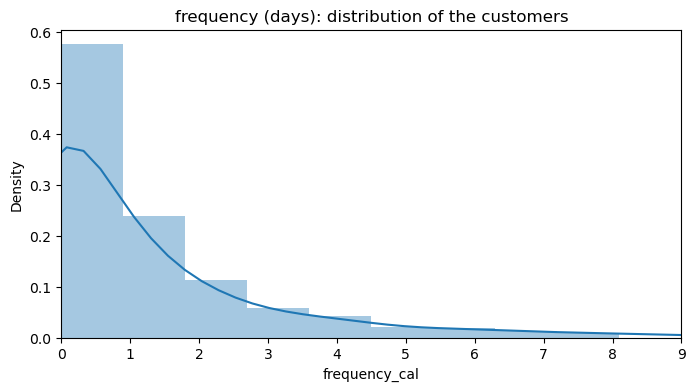

In [17]:
# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["frequency_cal"])
ax.set_xlim(0, max_freq)
ax.set_title("frequency (days): distribution of the customers");

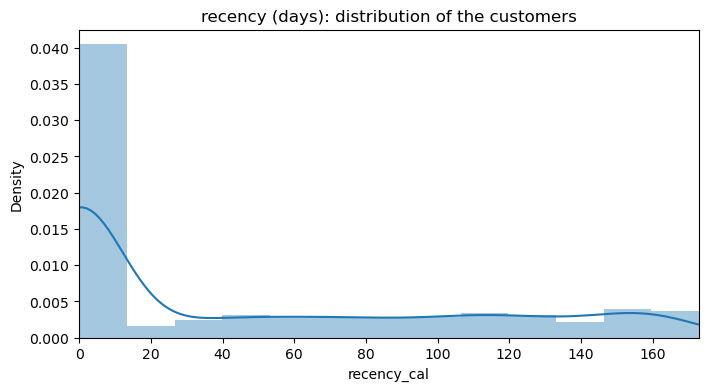

In [18]:
# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["recency_cal"])
ax.set_xlim(0, max_rec)
ax.set_title("recency (days): distribution of the customers");

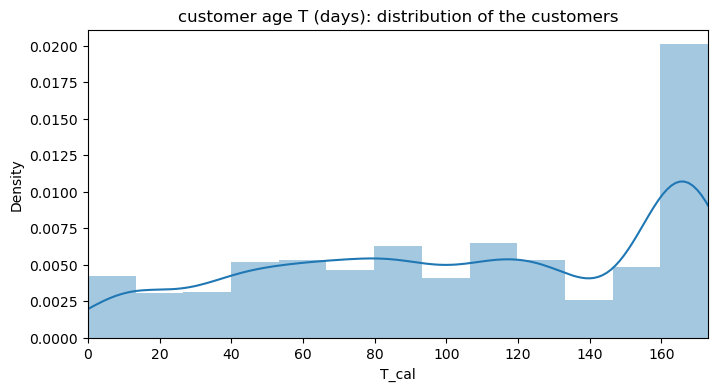

In [19]:
# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["T_cal"])
ax.set_xlim(0, max_T)
ax.set_title("customer age T (days): distribution of the customers");

### Fit the BG/NBD Model

In [20]:
#training: BG/NBD Model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = df_ch["frequency_cal"],
        recency = df_ch["recency_cal"],
        T = df_ch["T_cal"],
        weights = None,
        verbose = True,
        tol = 1e-06)

Optimization terminated successfully.
         Current function value: -0.234853
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48


<lifetimes.BetaGeoFitter: fitted with 2669 subjects, a: 0.00, alpha: 60.62, b: 0.03, r: 0.74>

In [21]:
# training: summary
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.741,0.039,0.665,0.817
alpha,60.617,3.515,53.728,67.505
a,0.000,0.000,-0.000,0.000
b,0.028,9.678,-18.941,18.997


<Figure size 1200x1200 with 0 Axes>

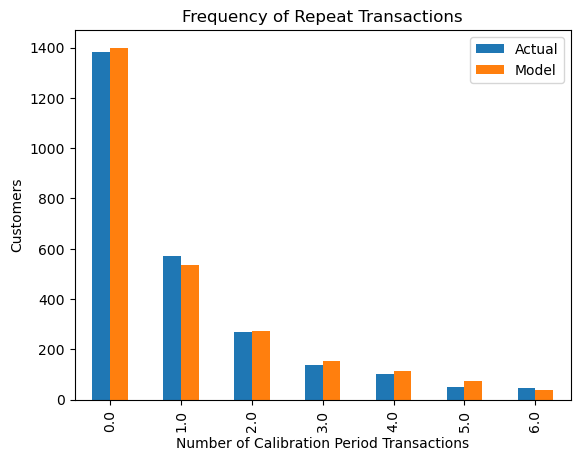

In [22]:
#training: Does the models reflect the actual data closely enough?
#frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(bgf);

X-axis: number of transactions in calibration period (whole training data)
Error: gap between two bars

The model is good because:

- accurate: Gaps between two bars are small
- stable: Two bars decline consistently.

If the pattern (two bars) is not declining consistently, the model is not stable.

There are both positive and negative errors, the error is random.

If the model prediction is always larger/smaller than actual, the model is not good because the error is not random, there’s still room for the model to be improved.

<Figure size 700x700 with 0 Axes>

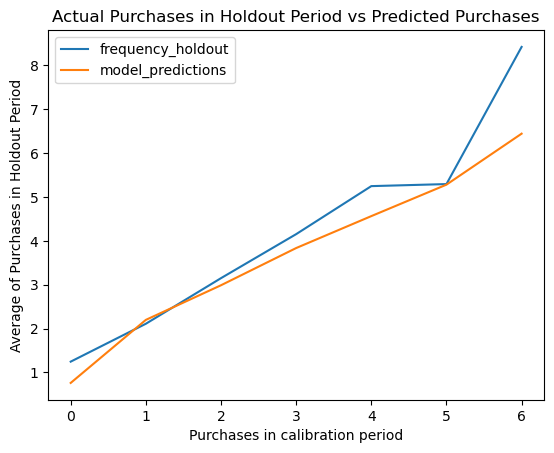

In [23]:
#testing: predicted vs actual purchases in holdout period
fig = plt.figure(figsize=(7, 7))
plot_calibration_purchases_vs_holdout_purchases(bgf, df_ch);

The model is good because model prediction (orange line) and true data (blue line) overlap.

## Fitting Model to Full Dataset

### Customer Recency, Frequency, Age T, Monetary Value (Revenues) for Each Customer

The lifetime package is based on transaction data only. For each customer, aggregate:

- recency: days between first and last purchase in the given period.
- frequency: number of repeated purchase in the given period. More precisely, it's the count of days the customer had a repeated purchase on.
- T: customer age, days since first purchase.
- monetary_value: transaction value in the given period.

In [24]:
#Determine recency, frequency, T, monetary value for each customer
df_rft = summary_data_from_transaction_data(
        transactions = df1,
        customer_id_col = "CustomerID",
        datetime_col = "InvoiceDate",
        monetary_value_col = "Revenues",
        observation_period_end = max_date,
        freq = "D")

pd.options.display.float_format = '{:,.0f}'.format
df_rft

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0,0,325,0
12347,6,365,367,600
12348,3,283,358,301
12349,0,0,18,0
12350,0,0,310,0
...,...,...,...,...
18280,0,0,277,0
18281,0,0,180,0
18282,1,119,126,78


In [25]:
df_rft.describe()

,frequency,recency,T,monetary_value
count,"4,339","4,339","4,339","4,339"
mean,3,131,223,307
std,6,132,118,"2,612"
min,0,0,0,0
25%,0,0,112,0
50%,1,93,248,177
75%,3,252,326,360
max,131,373,373,"168,470"


### Fitting the BG/NBD Model

In [26]:
#BG/NBD Model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = df_rft["frequency"],
        recency = df_rft["recency"],
        T = df_rft["T"],
        weights = None,
        verbose = True,
        tol = 1e-06)

pd.options.display.float_format = '{:,.3f}'.format
bgf.summary

Optimization terminated successfully.
         Current function value: -2.709794
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.827,0.027,0.774,0.879
alpha,68.910,2.618,63.779,74.041
a,0.002,0.006,-0.010,0.014
b,2.967,6.267,-9.317,15.250


In [27]:
#axis length
max_freq = int(df_rft["frequency"].max())
max_T = int(df_rft["T"].max())
max_rec = int(df_rft["recency"].max())
print(max_freq)

131


<Figure size 1200x1200 with 0 Axes>

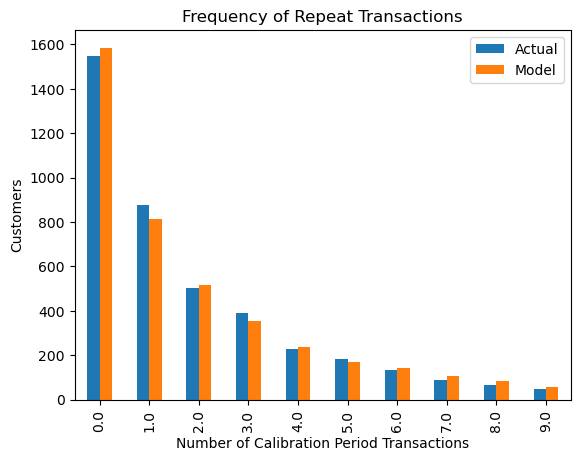

In [28]:
#frequency of repeat transaction: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(
            model = bgf,
            max_frequency = 10);

### Predictions

In [29]:
#Helper function: plot expected number of future purchases a customer 
#with frequency f and recency r will make in forecast period
def plot_freq_rec(t):
    fig = plt.figure(figsize=(7, 7))
    plot_frequency_recency_matrix(
            model = bgf,
            T = t,
            max_frequency = max_freq,
            max_recency = max_rec);

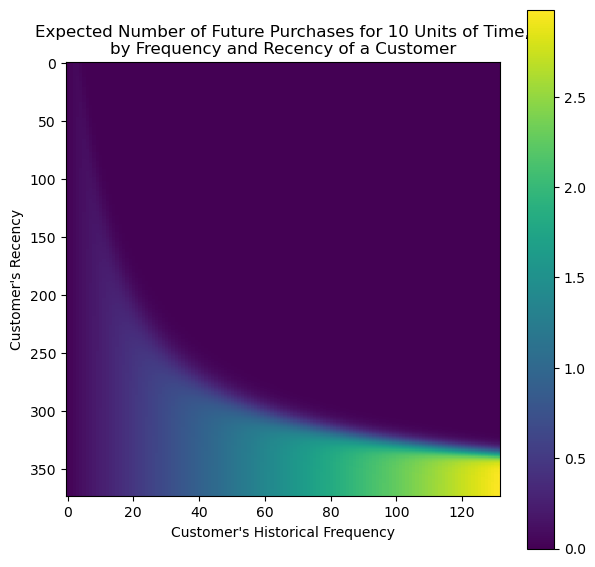

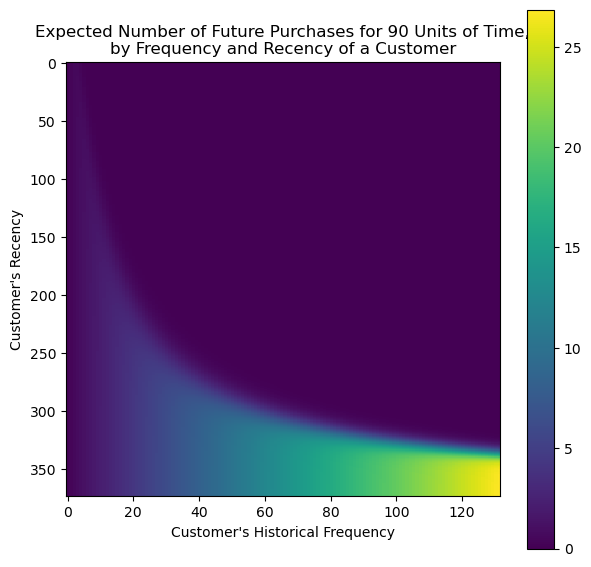

In [30]:
#Call plotter function for different forecast periods:
tFC = [10, 90]
_ = [plot_freq_rec(t) for t in tFC]

In [31]:
#Predict purchases for a selected customer for t days
t = 30
custID = 17841

df_rft_C = df_rft.loc[custID,:]
predC = bgf.predict(t,
                    df_rft_C["frequency"],
                    df_rft_C["recency"],
                    df_rft_C["T"])

print("Customer", custID, ":expected number of purchases within", t, "days =", f'{predC:.1f}')

Customer 17841 :expected number of purchases within 30 days = 7.6


In [32]:
#Selected customer: transactions
df1C = df1[df1["CustomerID"] == custID]
df1C.describe()

,Quantity,UnitPrice,Revenues
count,"7,847.000","7,847.000","7,847.000"
mean,2.940,2.529,5.224
std,6.727,2.936,9.942
min,1.000,0.040,0.290
25%,1.000,1.100,1.650
50%,1.000,1.650,2.950
75%,2.000,2.950,5.900
max,288.000,39.950,349.500


373


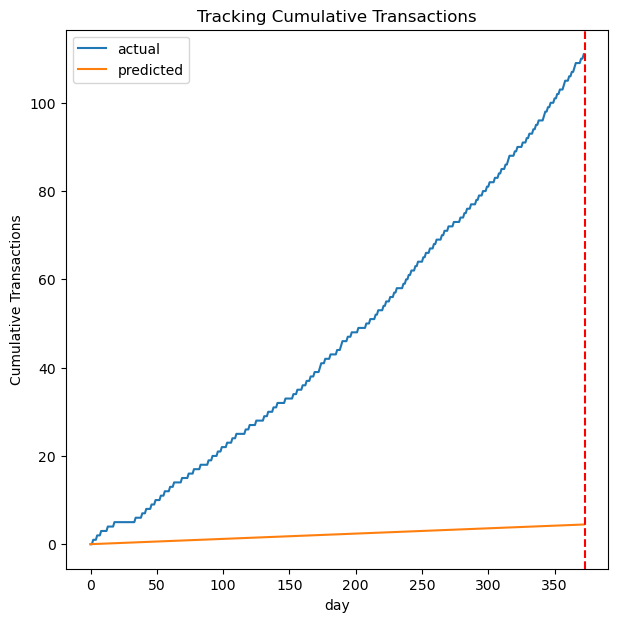

In [33]:
#X selected customer: cumulative transactions
max_date = df1["InvoiceDate"].max()
min_date = df1["InvoiceDate"].min()
span_days = (max_date - min_date).days
print(span_days)

fig = plt.figure(figsize=(7, 7))
plot_cumulative_transactions(
            model = bgf,
            transactions = df1C,
            datetime_col = "InvoiceDate",
            customer_id_col = "CustomerID",
            t = span_days,
            t_cal = span_days);

In [34]:
#Function to predict each customer's purchase over next t days
def predict_purch(df, t):
    df["predict_purch_" + str(t)] = \
        bgf.predict(
            t,
            df["frequency"],
            df["recency"],
            df["T"])

In [35]:
#Call function
t_FC = [10, 30, 60, 90]
_ = [predict_purch(df_rft, t) for t in t_FC]
pd.options.display.float_format = '{:,.1f}'.format
print("predicted number of purchases for each customer over next t days:")
df_rft

predicted number of purchases for each customer over next t days:


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
CustomerID,,,,,,,,
12346,0.0,0.0,325.0,0.0,0.0,0.1,0.1,0.2
12347,6.0,365.0,367.0,599.7,0.2,0.5,0.9,1.4
12348,3.0,283.0,358.0,301.5,0.1,0.3,0.5,0.8
12349,0.0,0.0,18.0,0.0,0.1,0.3,0.6,0.9
12350,0.0,0.0,310.0,0.0,0.0,0.1,0.1,0.2
...,...,...,...,...,...,...,...,...
18280,0.0,0.0,277.0,0.0,0.0,0.1,0.1,0.2
18281,0.0,0.0,180.0,0.0,0.0,0.1,0.2,0.3
18282,1.0,119.0,126.0,77.8,0.1,0.3,0.6,0.8


In [36]:
#Top 10 customer over next 30 days
print("Top 10 customers, by their prpedicted purchases over next 30 days")
df_rft.sort_values(by="predict_purch_30", ascending=False).head(10)

Top 10 customers, by their prpedicted purchases over next 30 days


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
CustomerID,,,,,,,,
14911,131.0,372.0,373.0,"1,093.7",3.0,8.9,17.9,26.8
12748,113.0,373.0,373.0,298.4,2.6,7.7,15.5,23.2
17841,111.0,372.0,373.0,364.5,2.5,7.6,15.2,22.8
15311,89.0,373.0,373.0,677.7,2.0,6.1,12.2,18.3
14606,88.0,372.0,373.0,135.9,2.0,6.0,12.1,18.1
12971,70.0,369.0,372.0,159.2,1.6,4.8,9.6,14.5
13089,65.0,367.0,369.0,893.7,1.5,4.5,9.0,13.5
14527,53.0,367.0,369.0,155.0,1.2,3.7,7.4,11.1
13798,52.0,371.0,372.0,706.7,1.2,3.6,7.2,10.8


In [37]:
#Recency, Frequency, T
dfx = df1[df1["CustomerID"] == 12352]
xmax_date = dfx["InvoiceDate"].max()
xmin_date = dfx["InvoiceDate"].min()

#Recency
print("Customer minimun date:", xmin_date)
print("Customer maximum date:", xmax_date)
xrec = (xmax_date - xmin_date).days
print("recency:", xrec)

#Age T
xmaxall_date = df1["InvoiceDate"].max()
print("Population maximum date:", xmaxall_date)
xage = (xmaxall_date - xmin_date).days
print("T:", xage)

#Frequency
xfreq = len(dfx[dfx["Quantity"] > 0].groupby("InvoiceDate"))-1
print("Frequency:", xfreq)

Customer minimun date: 2011-02-16
Customer maximum date: 2011-11-03
recency: 260
Population maximum date: 2011-12-09
T: 296
Frequency: 6


predicted average number of customer purchases over next 90 days:


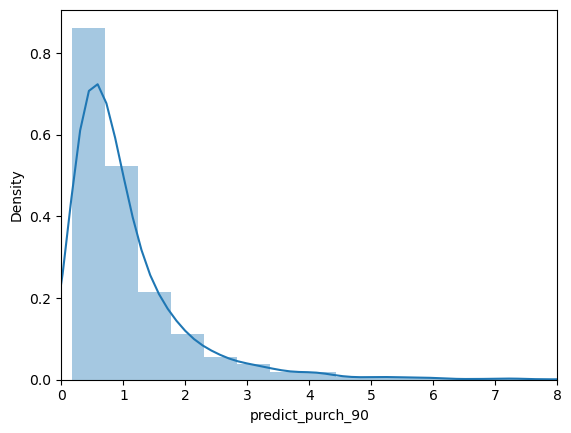

In [38]:
print("predicted average number of customer purchases over next 90 days:")
ax = sns.distplot(df_rft["predict_purch_90"]).set_xlim(0,8)

In [39]:
#Function probability of n repeat purchases within t days
def prob_purch(t, n):
    p = bgf.probability_of_n_purchases_up_to_time(t, n)
    return p

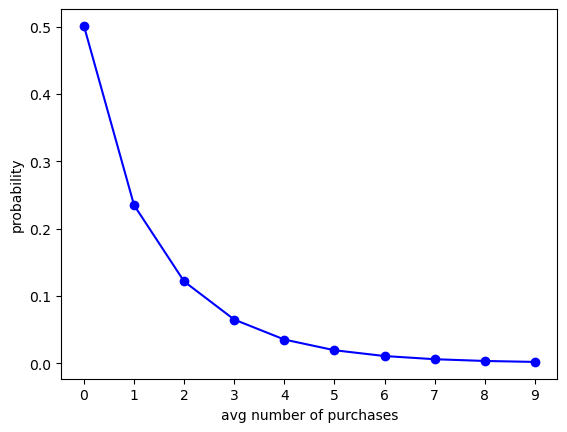

In [40]:
#Call function prob_purch
#t : forecast period (days)
#purch: number of repeat purchases
t = 90
purch = range(0,10,1)
probs = [prob_purch(t,n) for n in purch]
dict_probs = dict(zip(purch, probs))

plt.plot(purch, probs, '-o', color='blue')
plt.xlabel("avg number of purchases")
plt.ylabel("probability")
plt.xticks(purch)
plt.show()

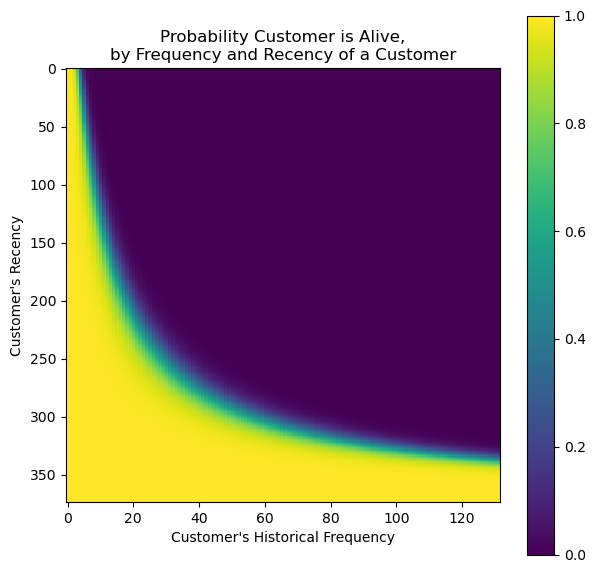

In [41]:
#Probability that a customer has not churned(='is alive')
#Based on customer's spesific recency r and frequency f
fig = plt.figure(figsize=(7,7))
plot_probability_alive_matrix(
                    model = bgf,
                    max_frequency = max_freq,
                    max_recency = max_rec);

In [42]:
#Probability that a customer is alive for each customer in dataframe
prob_alive = bgf.conditional_probability_alive(
                frequency = df_rft["frequency"],
                recency = df_rft["recency"],
                T = df_rft["T"])

df_rft["prob_alive"] = prob_alive
pd.options.display.float_format = '{:,.2f}'.format
df_rft.describe()

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
count,"4,339.00","4,339.00","4,339.00","4,339.00","4,339.00","4,339.00","4,339.00","4,339.00","4,339.00"
mean,2.86,130.74,222.78,306.94,0.12,0.36,0.72,1.08,1.00
std,5.95,132.21,117.88,"2,612.45",0.14,0.42,0.85,1.27,0.01
min,0.00,0.00,0.00,0.00,0.02,0.06,0.11,0.17,0.75
25%,0.00,0.00,112.00,0.00,0.05,0.15,0.30,0.45,1.00
50%,1.00,93.00,248.00,176.94,0.09,0.26,0.51,0.77,1.00
75%,3.00,252.00,326.00,360.16,0.14,0.42,0.85,1.27,1.00
max,131.00,373.00,373.00,"168,469.60",2.98,8.95,17.90,26.84,1.00


In [43]:
#Show customers who are alive, but with less than 90% certainty
df_rft[df_rft["prob_alive"] < 0.9]

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
CustomerID,,,,,,,,,
13093,6.00,98.00,373.00,"1,172.18",0.13,0.39,0.79,1.18,0.85
15107,5.00,61.00,372.00,40.70,0.10,0.30,0.60,0.89,0.75
15235,9.00,156.00,373.00,240.89,0.20,0.59,1.18,1.77,0.89
16725,5.00,69.00,371.00,131.77,0.11,0.32,0.65,0.97,0.81


## Customer Lifetime Value: The Gamma-Gamma Model

### Fitting the Gamma-Gamma Model

In [44]:
#Select customers with monetary value > 0
df_rftv = df_rft[df_rft["monetary_value"]>0]
pd.options.display.float_format = '{:,.2f}'.format
df_rftv.describe()

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
count,"2,790.00","2,790.00","2,790.00","2,790.00","2,790.00","2,790.00","2,790.00","2,790.00","2,790.00"
mean,4.45,203.33,260.12,477.36,0.16,0.48,0.95,1.43,1.00
std,6.93,111.46,101.48,"3,245.62",0.16,0.49,0.97,1.46,0.01
min,1.00,1.00,9.00,1.00,0.04,0.12,0.24,0.37,0.75
25%,1.00,106.00,197.25,187.17,0.07,0.22,0.45,0.67,1.00
50%,3.00,211.00,284.00,309.47,0.12,0.36,0.71,1.07,1.00
75%,5.00,301.75,358.00,458.37,0.18,0.55,1.11,1.66,1.00
max,131.00,373.00,373.00,"168,469.60",2.98,8.95,17.90,26.84,1.00


In [45]:
#Gamma-Gamma Model requires a Pearson correlation close to 0
#between purchase frequency and monetary value
corr_matrix = df_rftv[["monetary_value", "frequency"]].corr()
corr = corr_matrix.iloc[1,0]
print("Pearson correlation: %.3f" % corr)

Pearson correlation: 0.016


In [46]:
#Fitting the Gamma-Gamma Model
ggf = GammaGammaFitter(penalizer_coef = 1e-06)
ggf.fit(
        frequency = df_rftv["frequency"],
        monetary_value = df_rftv["monetary_value"],
        weights = None,
        verbose = True,
        tol = 1e-06,
        q_constraint = True)

pd.options.display.float_format = '{:,.3f}'.format
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,4.176,0.186,3.811,4.541
q,2.415,0.070,2.279,2.552
v,149.875,8.304,133.600,166.151


### Predictions

In [47]:
#Estimate the average transaction value of each customer, based on frequenct and monetary value
exp_avg_rev = ggf.conditional_expected_average_profit(
                df_rftv["frequency"],
                df_rftv["monetary_value"])

df_rftv["exp_avg_rev"] = exp_avg_rev
df_rftv["avg_rev"] = df_rftv["monetary_value"]
df_rftv["error_rev"] = df_rftv["exp_avg_rev"] - df_rftv["avg_rev"]

mape = mean_absolute_percentage_error(exp_avg_rev, df_rftv["monetary_value"])
print("MAPE of predicted revenues:", f'{mape:.2f}')

pd.options.display.float_format = '{:,.3f}'.format
df_rftv.head()

MAPE of predicted revenues: 0.12


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive,exp_avg_rev,avg_rev,error_rev
CustomerID,,,,,,,,,,,,
12347,6.000,365.000,367.000,599.702,0.157,0.470,0.939,1.409,1.000,591.285,599.702,-8.417
12348,3.000,283.000,358.000,301.480,0.090,0.269,0.537,0.806,0.999,315.769,301.480,14.289
12352,6.000,260.000,296.000,368.257,0.187,0.561,1.122,1.683,1.000,372.213,368.257,3.956
12356,2.000,303.000,325.000,269.905,0.072,0.215,0.430,0.645,0.999,294.878,269.905,24.973
12358,1.000,149.000,150.000,683.200,0.083,0.250,0.500,0.750,0.999,622.216,683.200,-60.984


In [48]:
#Compute customer lifetime value
#DISCOUNT_a : annual discount rate
#LIFE : lifetime expected for the customers in months
DISCOUNT_a = 0.06
LIFE = 3

#Monthly discount rate
discount_m = (1 + DISCOUNT_a)**(1/12) - 1

#Expected customer lifetime values
clv = ggf.customer_lifetime_value(
        transaction_prediction_model = bgf,
        frequency = df_rftv["frequency"],
        recency = df_rftv["recency"],
        T = df_rftv["T"],
        monetary_value = df_rftv["monetary_value"],
        time = LIFE,
        freq = "D",
        discount_rate = discount_m)

df_rftv.insert(0, "CLV", clv)
df_rftv.describe().T

,count,mean,std,min,25%,50%,75%,max
CLV,"2,790.000",727.807,"2,629.697",40.048,193.663,347.446,650.436,"74,795.062"
frequency,"2,790.000",4.454,6.930,1.000,1.000,3.000,5.000,131.000
recency,"2,790.000",203.329,111.460,1.000,106.000,211.000,301.750,373.000
T,"2,790.000",260.121,101.480,9.000,197.250,284.000,358.000,373.000
monetary_value,"2,790.000",477.359,"3,245.622",1.000,187.165,309.473,458.371,"168,469.600"
predict_purch_10,"2,790.000",0.159,0.162,0.041,0.075,0.119,0.185,2.983
predict_purch_30,"2,790.000",0.476,0.486,0.122,0.224,0.356,0.554,8.949
predict_purch_60,"2,790.000",0.952,0.973,0.244,0.448,0.711,1.107,17.896
predict_purch_90,"2,790.000",1.428,1.459,0.365,0.672,1.067,1.660,26.843
prob_alive,"2,790.000",0.998,0.007,0.752,0.999,0.999,1.000,1.000


In [49]:
df_rftv.sort_values(by="CLV", ascending=False)

,CLV,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive,exp_avg_rev,avg_rev,error_rev
CustomerID,,,,,,,,,,,,,
16446,"74,795.062",1.000,205.000,205.000,"168,469.600",0.067,0.200,0.400,0.600,0.999,"125,940.166","168,469.600","-42,529.434"
14646,"59,708.141",44.000,353.000,354.000,"6,366.706",1.060,3.180,6.359,9.537,1.000,"6,321.425","6,366.706",-45.281
18102,"48,731.801",25.000,367.000,367.000,"9,349.477",0.592,1.777,3.554,5.331,1.000,"9,230.351","9,349.477",-119.126
17450,"40,113.992",26.000,359.000,367.000,"7,404.690",0.615,1.846,3.692,5.537,1.000,"7,315.109","7,404.690",-89.581
14096,"35,254.043",16.000,97.000,101.000,"4,071.434",0.990,2.970,5.939,8.908,1.000,"3,996.161","4,071.434",-75.273
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12755,46.719,1.000,85.000,365.000,17.550,0.042,0.126,0.252,0.377,0.996,125.048,17.550,107.498
14865,45.436,1.000,365.000,372.000,15.000,0.041,0.124,0.248,0.373,0.999,123.144,15.000,108.144
17194,45.141,1.000,87.000,360.000,10.000,0.042,0.127,0.254,0.382,0.996,119.409,10.000,109.409


## Customer Segmentation Using The KMeans Algorithm

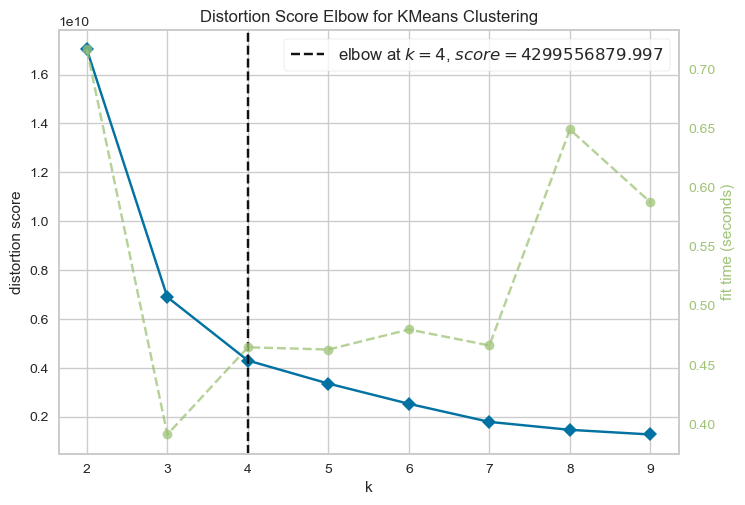

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [50]:
from yellowbrick.cluster import KElbowVisualizer

#Instantiate the clustering model and visualizer
km_model = KMeans()
visualizer = KElbowVisualizer(km_model, k=(2,10))

visualizer.fit(df_rftv)
visualizer.show()

We can see that the optimal number of clusters or the elbow value is 4.

In [51]:
km_model = KMeans(n_clusters=4)
km_model.fit(df_rftv)

#Creating new variabel called cluster whose are the corresponding cluster for each point
df_rftv['cluster'] = km_model.labels_

In [52]:
#Grouping by clusters
df_clusters = df_rftv.groupby(['cluster'])['CLV']\
                    .agg(['mean', "count"])\
                    .reset_index()

df_clusters.columns = ["clusters", "avg_CLV", "n_customers"]

df_clusters['perct_customers'] = (df_clusters['n_customers']/df_clusters['n_customers']\
                                    .sum())*100

df_clusters

,clusters,avg_CLV,n_customers,perct_customers
0,0,519.015,2752,98.638
1,1,"74,795.062",1,0.036
2,2,"39,928.486",6,0.215
3,3,"9,286.732",31,1.111


In [53]:
#Rename the columns
df_rftv['customer_category'] = df_rftv['cluster']\
                            .replace({0:"Bronze", 1:"Platinum", 2:"Gold", 3:"Silver"})

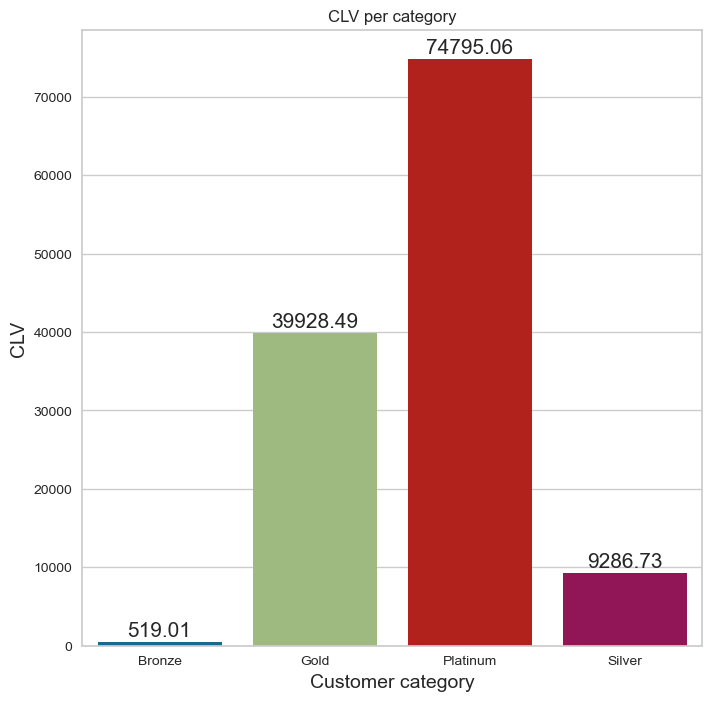

In [54]:
#Grouping by customer category
df_cat = pd.DataFrame(df_rftv.groupby(['customer_category'])['CLV']\
                     .agg('mean')).reset_index()

#Defining the plot size
plt.figure(figsize=(8,8))

#Defining the values for x-axis, y-axis
#and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="CLV", data=df_cat)

#Iterating over the bars one-by-one
for bar in plots.patches:
    # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                  (bar.get_x() + bar.get_width() / 2,
                  bar.get_height()), ha='center', va='center',
                  size=15, xytext=(0, 8), textcoords='offset points',)

plt.xlabel("Customer category", size=14)

#Setting the label for y-axis
plt.ylabel("CLV", size=14)

#Setting the title for the graph
plt.title("CLV per category")

#Finally showing the plot
plt.show()

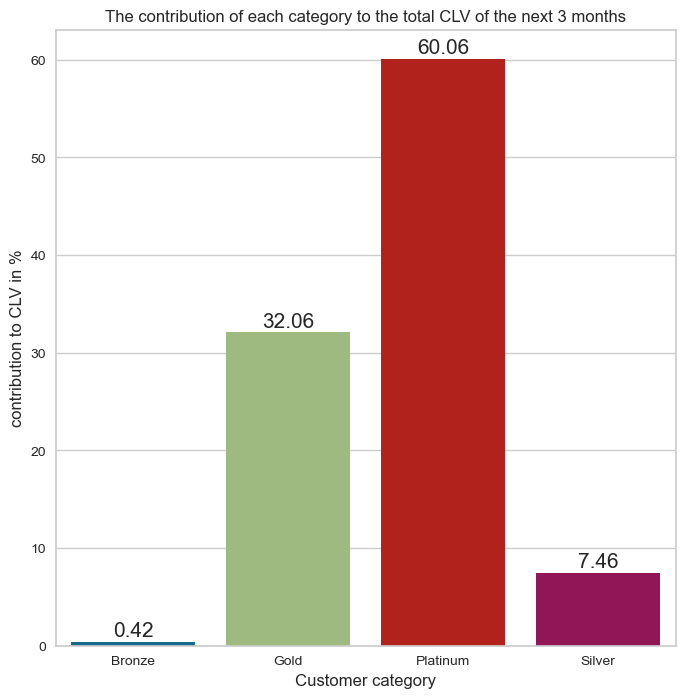

In [55]:
df_cat["contribution_to_CLV"] = df_cat['CLV']/df_cat['CLV'].sum()*100

#Define the plot size
plt.figure(figsize=(8,8))

#Define the value for x-aixs, y-axis
#and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="contribution_to_CLV", data=df_cat)

#Iterating over the bars one-by-one
for bar in plots.patches:
    # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                  (bar.get_x() + bar.get_width() / 2,
                  bar.get_height()), ha='center', va='center',
                  size=15, xytext=(0, 8), textcoords='offset points',)
    
plt.xlabel("Customer category", size=12)

#Setting the label for y-axis
plt.ylabel("contribution to CLV in %", size=12)

#Setting the title for the graph
plt.title("The contribution of each category to the total CLV of the next 3 months")

plt.show()


### Analyzing The Frequency Metric

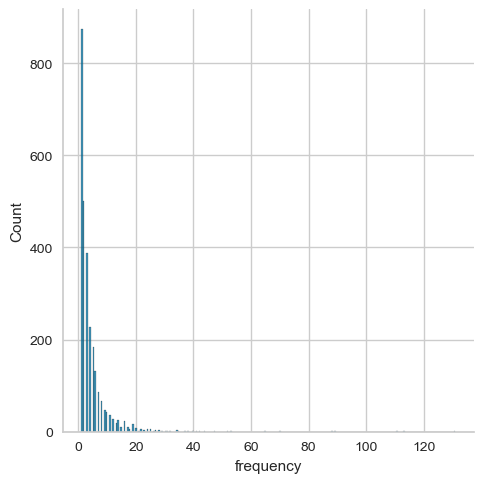

In [56]:
sns.displot(df_rftv['frequency'])
plt.show()

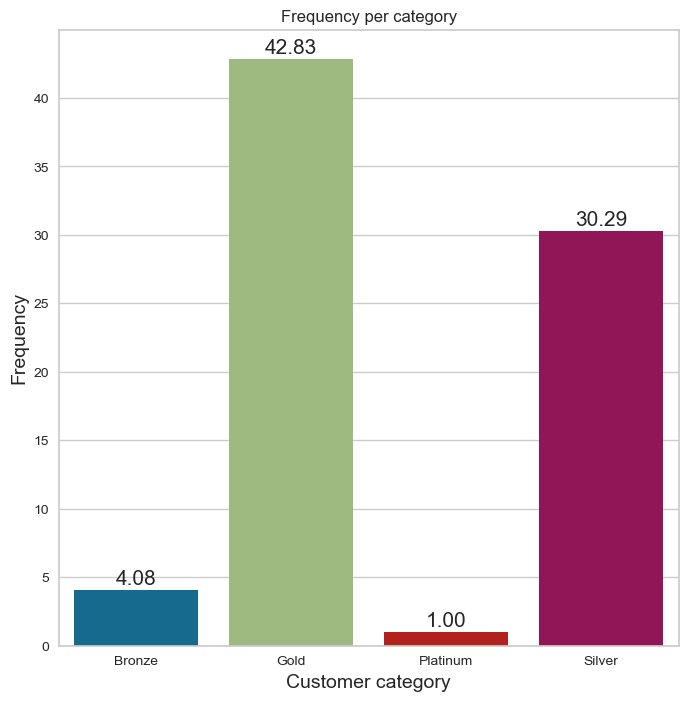

In [57]:
df_freq = pd.DataFrame(df_rftv.groupby(['customer_category'])['frequency']\
                      .mean().reset_index())

#Define the plot size
plt.figure(figsize=(8,8))

#Define the value for x-aixs, y-axis
#and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="frequency", data=df_freq)

#Iterating over the bars one-by-one
for bar in plots.patches:
    # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                  (bar.get_x() + bar.get_width() / 2,
                  bar.get_height()), ha='center', va='center',
                  size=15, xytext=(0, 8), textcoords='offset points',)
    
plt.xlabel("Customer category", size=14)

#Setting the label for y-axis
plt.ylabel("Frequency", size=14)

#Setting the title for the graph
plt.title("Frequency per category")

plt.show()



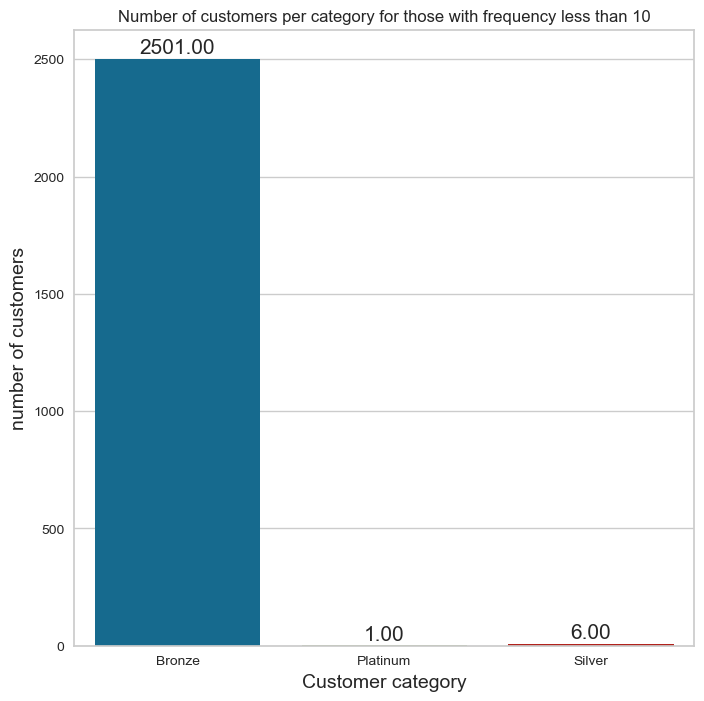

In [58]:
#Getting the number of customer per category for those with a frequency less than 10
df_freq_2 = pd.DataFrame(df_rftv[df_rftv['frequency'] < 10]\
                        .groupby(['customer_category'])['customer_category']\
                        .agg('count'))

df_freq_2.columns = ['n_customers']

df_freq_2 = df_freq_2.reset_index()

#Define the plot size
plt.figure(figsize=(8,8))

#Define the value for x-aixs, y-axis
#and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="n_customers", data=df_freq_2)

#Iterating over the bars one-by-one
for bar in plots.patches:
    # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                  (bar.get_x() + bar.get_width() / 2,
                  bar.get_height()), ha='center', va='center',
                  size=15, xytext=(0, 8), textcoords='offset points',)
    
plt.xlabel("Customer category", size=14)

#Setting the label for y-axis
plt.ylabel("number of customers", size=14)

#Setting the title for the graph
plt.title("Number of customers per category for those with frequency less than 10")

plt.show()


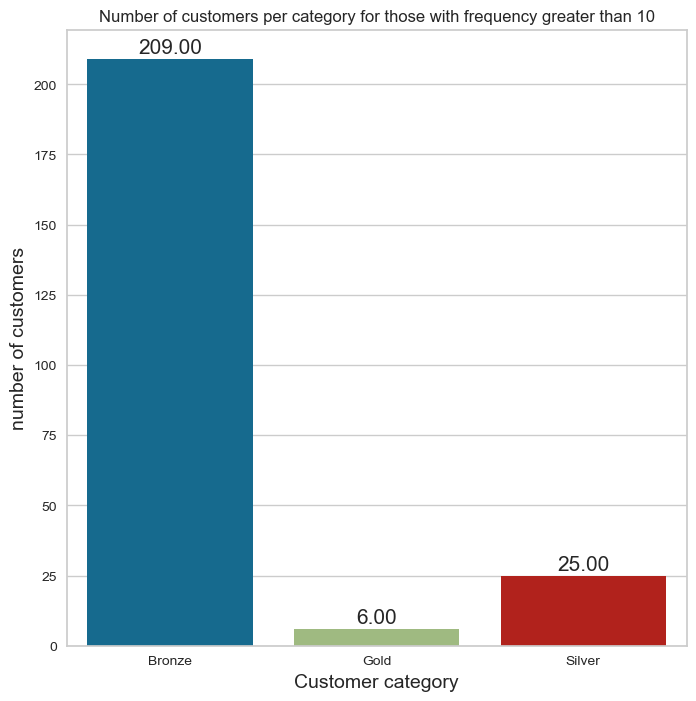

In [59]:
#Getting the number of customer per category for those with a frequency greater than 10
df_freq_1 = pd.DataFrame(df_rftv[df_rftv['frequency'] > 10]\
                        .groupby(['customer_category'])['customer_category']\
                        .agg('count'))

df_freq_1.columns = ['n_customers']

df_freq_1 = df_freq_1.reset_index()

#Define the plot size
plt.figure(figsize=(8,8))

#Define the value for x-aixs, y-axis
#and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="n_customers", data=df_freq_1)

#Iterating over the bars one-by-one
for bar in plots.patches:
    # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                  (bar.get_x() + bar.get_width() / 2,
                  bar.get_height()), ha='center', va='center',
                  size=15, xytext=(0, 8), textcoords='offset points',)
    
plt.xlabel("Customer category", size=14)

#Setting the label for y-axis
plt.ylabel("number of customers", size=14)

#Setting the title for the graph
plt.title("Number of customers per category for those with frequency greater than 10")

plt.show()


### Analyzing The Monetary Value

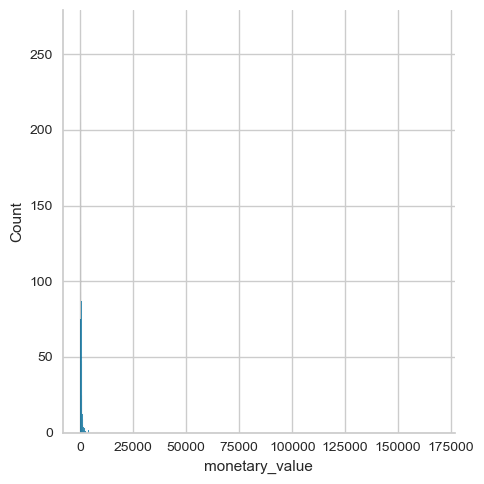

In [60]:
sns.displot(df_rftv['monetary_value'])
plt.show()

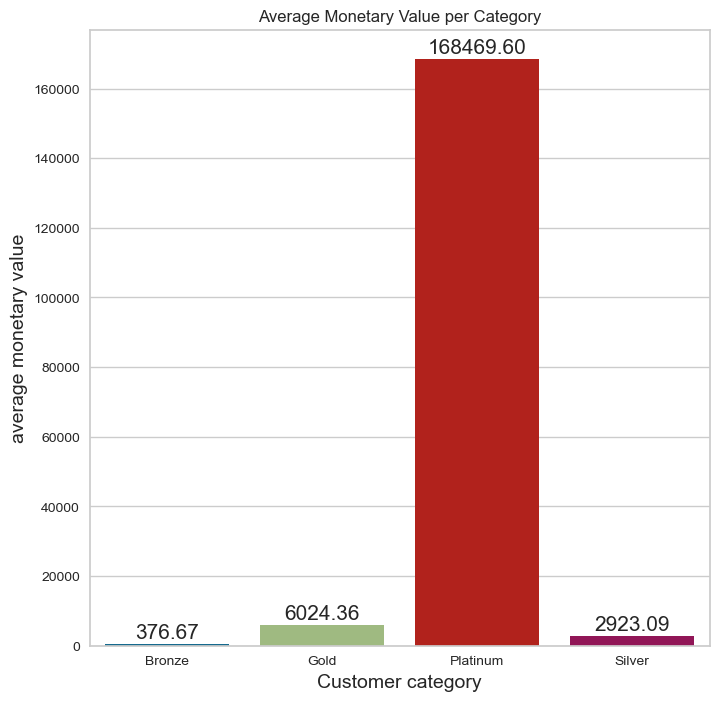

In [61]:
-

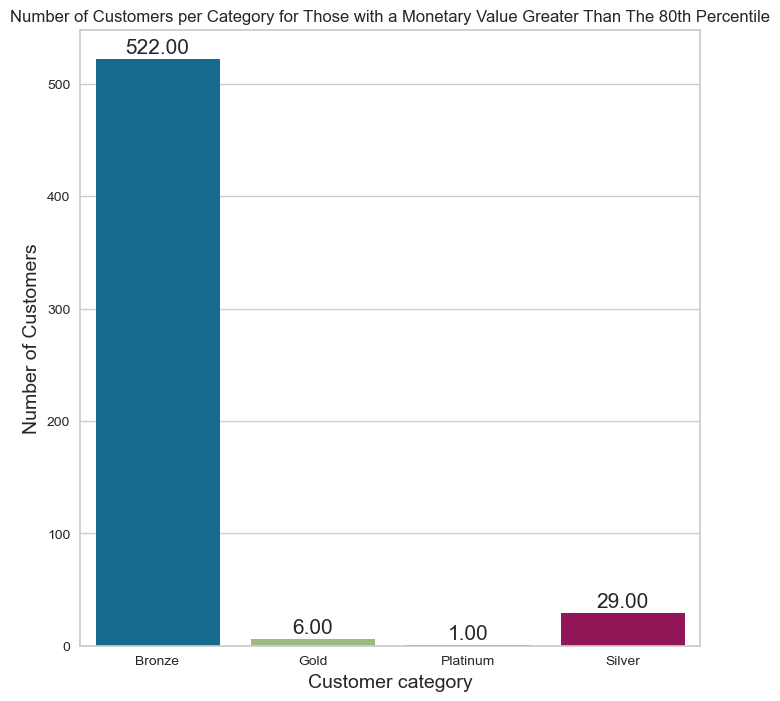

In [62]:
# Getting the number of customers per category for those with a monetary value greater than the 80th percentile

#Calculate the 80th percentile
perct = df_rftv['monetary_value'].quantile(q=0.8)

df_mon_1 = pd.DataFrame(df_rftv[df_rftv['monetary_value'] > perct]\
                       .groupby(['customer_category'])['customer_category']\
                       .agg('count'))

df_mon_1.columns = ['n_customers']

df_mon_1 = df_mon_1.reset_index()

#Define the plot size
plt.figure(figsize=(8,8))

#Define the value for x-aixs, y-axis
#and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="n_customers", data=df_mon_1)

#Iterating over the bars one-by-one
for bar in plots.patches:
    # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                  (bar.get_x() + bar.get_width() / 2,
                  bar.get_height()), ha='center', va='center',
                  size=15, xytext=(0, 8), textcoords='offset points',)
    
plt.xlabel("Customer category", size=14)

#Setting the label for y-axis
plt.ylabel("Number of Customers", size=14)

plt.title("Number of Customers per Category for Those with a Monetary Value Greater Than The 80th Percentile")

plt.show()

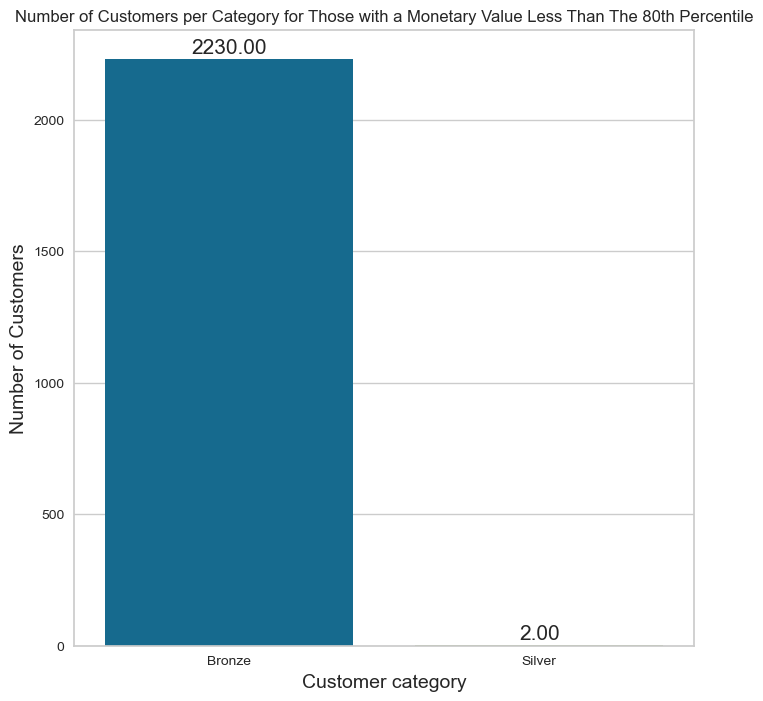

In [63]:
# Getting the number of customers per category for those with a monetary value less than the 80th percentile

#Calculate the 80th percentile
perct = df_rftv['monetary_value'].quantile(q=0.8)

df_mon_2 = pd.DataFrame(df_rftv[df_rftv['monetary_value'] < perct]\
                       .groupby(['customer_category'])['customer_category']\
                       .agg('count'))

df_mon_2.columns = ['n_customers']

df_mon_2 = df_mon_2.reset_index()

#Define the plot size
plt.figure(figsize=(8,8))

#Define the value for x-aixs, y-axis
#and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="n_customers", data=df_mon_2)

#Iterating over the bars one-by-one
for bar in plots.patches:
    # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                  (bar.get_x() + bar.get_width() / 2,
                  bar.get_height()), ha='center', va='center',
                  size=15, xytext=(0, 8), textcoords='offset points',)
    
plt.xlabel("Customer category", size=14)

#Setting the label for y-axis
plt.ylabel("Number of Customers", size=14)

plt.title("Number of Customers per Category for Those with a Monetary Value Less Than The 80th Percentile")

plt.show()